In [8]:
import numpy as np
import random

from tqdm import tqdm
from collections import Counter
from utils_import import load_data
from utils_preprocess import split_data, compute_energy_matrix_and_labels
from utils_clustering import create_cluster, cluster_mapping
from utils_test import predict_labels
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

random.seed(1337)
np.random.seed(1337)

# Asumption: all signals consist of 50k samples
n_samples = 50000
interv = 1024 # Hyperparameter 1
array_length = (n_samples // interv) - 1
n_frec_div = 16 # Hyperparameter 2

# Load data
signals_clean = load_data('../dataset/Jamming/Clean', '../dataset/Jamming/metadata.csv')
signals_narrowband = load_data('../dataset/Jamming/Narrowband', '../dataset/Jamming/metadata.csv')
signals_wideband = load_data('../dataset/Jamming/Wideband', '../dataset/Jamming/metadata.csv')

# Partition train=0.8, test=0.2
clean_train, clean_test = split_data(signals_clean, 0.8)
narrowband_train, narrowband_test = split_data(signals_narrowband, 0.8)
wideband_train, wideband_test = split_data(signals_wideband, 0.8)

train = []
train.extend(clean_train)  
train.extend(narrowband_train)  
train.extend(wideband_train) 
test = [] 
test.extend(clean_test)  
test.extend(narrowband_test) 
test.extend(wideband_test) 

print(f"Nº señales entrenamiento: {len(train)}")
print(f"Nº señales test: {len(test)}")

random.shuffle(train)
random.shuffle(test)

class_mapping = {"Clean": 0, "Narrowband": 1, "Wideband": 2}


Cargando datos desde cache...
Cargando datos desde cache...
Cargando datos desde cache...
Nº señales entrenamiento: 18000
Nº señales test: 4500


(48, 1024)


/Users/stelin41/Library/CloudStorage/OneDrive-UniversidadedeSantiagodeCompostela/usc/materias_3_1/ProyectoIntegrador/ProyectoIntegradorI/.env/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/stelin41/Library/CloudStorage/OneDrive-UniversidadedeSantiagodeCompostela/usc/materias_3_1/ProyectoIntegrador/ProyectoIntegradorI/.env/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


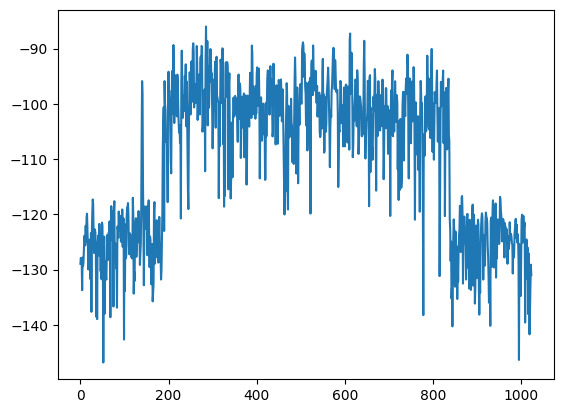

{'Data': array([ 0.01702932+0.00286874j,  0.02774132+0.00521866j,
        0.02618488+0.01235999j, ...,  0.01052888+0.00598163j,
       -0.01043733-0.03170872j, -0.0191351 -0.02749717j], dtype=complex64), 'Class': 'Narrowband', 'JammingStartTime': np.int64(17829), 'AveragePower_dB': np.float64(-28.994922637939453)}
(48, 1024)


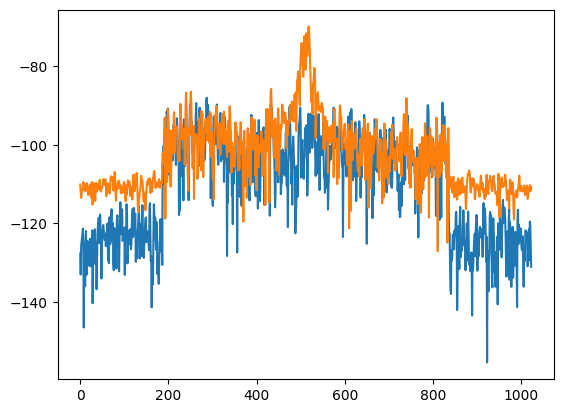

[[-123.33749 +0.j -127.05064 +0.j -127.24091 +0.j ... -128.02156 +0.j
  -127.188644+0.j -120.017006+0.j]
 [-127.653595+0.j -133.00937 +0.j -125.66028 +0.j ... -120.56943 +0.j
  -126.218956+0.j -131.07649 +0.j]
 [-110.09812 +0.j -112.09546 +0.j -113.480545+0.j ... -111.39183 +0.j
  -111.732635+0.j -110.66058 +0.j]]
[[0.01709301 0.02465306 0.00585685 0.03279049 0.00424104 0.08655486
  0.01156658 0.04010358 0.03406518 0.00327111 0.01449108 0.03116161
  0.01400818 0.03609561 0.01882859 0.00099398]
 [0.25485104 0.20698859 0.22551571 0.05105717 0.00926292 0.10495551
  0.04385453 0.31069937 0.22906435 0.03137966 0.01159088 0.06936903
  0.00419458 0.25572985 0.2362047  0.2328279 ]]
----------------------------------------------------------------------------------------------------
{'Data': array([ 0.02456739+0.00534074j,  0.04110842-0.04150516j,
        0.04022339-0.02316354j, ..., -0.00936918+0.02069154j,
        0.0318308 -0.01031525j,  0.01440473-0.01443525j], dtype=complex64), 'Class': 'Na

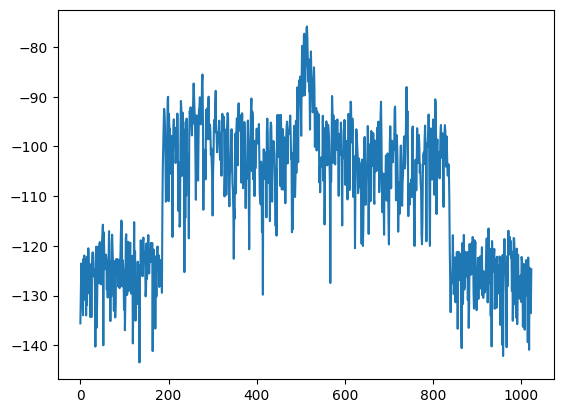

In [9]:
from utils_preprocess import *
import matplotlib.pyplot as plt

d = train[0]["Data"] # Clean
f = signal_interval(d)
print(f.shape)
plt.plot(f[20])
plt.show()

d = train[1]["Data"] # Narrowband
start = train[1]['JammingStartTime']//1024
print(train[1])
f = signal_interval(d)
print(f.shape)
plt.plot(f[start-1])
plt.plot(f[start])
plt.show()
t = f[start-2:start+1]
print(t)
e=energy_arrays(t, 16)
print(e)
print("-"*100)

d = train[3]["Data"] # Wideband
start = train[3]['JammingStartTime']//1024
print(train[3])
f = signal_interval(d)
print(f.shape)
plt.plot(f[start])
plt.show()


In [10]:
# 1) -- Train --

# Building energy arrays for each train signal (x=window samples, y=frecuency divisions z=signal)
train_energy_dif_matrix, sample_labels = compute_energy_matrix_and_labels(train, n_samples, interv, n_frec_div, class_mapping)
train_energy_dif_matrix = np.abs(train_energy_dif_matrix)
# Creating K-Means model based on energy arrays
cluster = create_cluster(train_energy_dif_matrix, k=3)
print(f"\n--- Centros de cluster ---\n{cluster.cluster_centers_}") 

# Mapping cluster to original classes
cluster_map = cluster_mapping(cluster.labels_, sample_labels, class_mapping)
print(f"\nMapping clusters to predominant classes: {cluster_map}")

18000it [00:58, 307.11it/s]



--- Centros de cluster ---
[[0.24239873 0.22502578 0.21722197 0.02514801 0.02517074 0.0615834
  0.10381873 0.17373083 0.16291624 0.10305788 0.06286557 0.04065665
  0.02826748 0.21784357 0.22242    0.24016408]
 [0.02051109 0.02060134 0.0210244  0.02056994 0.021099   0.02064131
  0.02084392 0.02197928 0.02204112 0.0207846  0.02042891 0.01987076
  0.02015129 0.02186048 0.02215753 0.0217317 ]
 [0.08366039 0.07558303 0.07521959 0.02144605 0.02195424 0.22609649
  0.37147266 0.37784164 0.35499827 0.37166058 0.22589346 0.02442283
  0.02107786 0.07618649 0.07546933 0.08305307]]

Clases en el cluster 0: Counter({np.int8(1): 5367, np.int8(2): 4459, np.int8(0): 40})
Clase mayoritaria: 1, Narrowband

Clases en el cluster 1: Counter({np.int8(0): 281960, np.int8(1): 276633, np.int8(2): 266705})
Clase mayoritaria: 0, Clean

Clases en el cluster 2: Counter({np.int8(2): 10836})
Clase mayoritaria: 2, Wideband

Mapping clusters to predominant classes: {np.int32(0): np.int8(1), np.int32(1): np.int8(0), np

In [11]:
# 2) -- Test -- 

test_energy_dif_matrix, y_true = compute_energy_matrix_and_labels(test, n_samples, interv, n_frec_div, class_mapping)
test_energy_dif_matrix = np.abs(test_energy_dif_matrix)

y_pred = [cluster_map[label] for label in cluster.predict(test_energy_dif_matrix)]
# Nota: por el momento predice en exceso clase 1 (corregir desbalanceo, clase mayoritaria tiene muchas más ocurrencias)
print(np.bincount(y_pred))

# True signal classification
signal_true = np.zeros(len(test), dtype=np.int8)
for i, signal in enumerate(test):
    signal_true[i] = class_mapping[signal["Class"]]

# Predicted signal classification
signal_pred = predict_labels(y_pred, N=len(test), array_length=array_length)

4500it [00:14, 307.61it/s]

[206266   2513   2721]


In [12]:
# 3) -- Metrics --

# Accuracy
acc = accuracy_score(signal_true, signal_pred)
print(f"\nAccuracy: {acc}")        

# Confusion Matrix
cm = confusion_matrix(signal_true, signal_pred)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:")
print(classification_report(signal_true, signal_pred))


Accuracy: 0.3333333333333333

Confusion Matrix:
[[1500    0    0]
 [1500    0    0]
 [1500    0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      1500
           1       0.00      0.00      0.00      1500
           2       0.00      0.00      0.00      1500

    accuracy                           0.33      4500
   macro avg       0.11      0.33      0.17      4500
weighted avg       0.11      0.33      0.17      4500



/Users/stelin41/Library/CloudStorage/OneDrive-UniversidadedeSantiagodeCompostela/usc/materias_3_1/ProyectoIntegrador/ProyectoIntegradorI/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stelin41/Library/CloudStorage/OneDrive-UniversidadedeSantiagodeCompostela/usc/materias_3_1/ProyectoIntegrador/ProyectoIntegradorI/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stelin41/Library/CloudStorage/OneDrive-UniversidadedeSantiagodeCompostela/usc/materias_3_1/Proyec

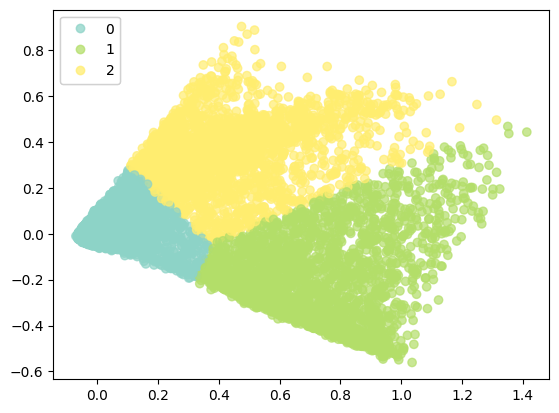

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

pca = PCA(2) 
X = np.abs(test_energy_dif_matrix)
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
kmeans =KMeans(n_clusters=3).fit(X)
pca_data['cluster'] = pd.Categorical(kmeans.labels_)

fig,ax = plt.subplots()
scatter = ax.scatter(pca_data['PC1'], pca_data['PC2'],c=pca_data['cluster'],cmap='Set3',alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="")
ax.add_artist(legend1)
plt.show()